Author: Thibeau Wouters

# Physical Modelling of Complex Systems - Assignment 9

##### Import packages:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

import cmath

In [2]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (8, 4),
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
     "legend.fontsize":24,
    "lines.markersize" : 10,
     "legend.fontsize": 16,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

# Brusselator model as toy model for the Belousov-Zhabotinsky reaction 

The Brusselator model is (see report for more details) $$ \begin{align}
    \frac{\partial u}{\partial t} &= \gamma(a - (b+1)u + u^2v) + \frac{\partial^2u}{\partial x^2} \\
    \frac{\partial v}{\partial t} &= \gamma(b u - u^2v) + d \frac{\partial^2 v}{\partial x^2} \, .
\end{align} $$

## 9.1 - Homogeneous steady state solutions

Save the default values.

In [3]:
d = 22.4/2.8; a = 1.5

The homogeneous steady state solutions are $$ (u_0, v_0) = \left( a, \frac{b}{a} \right) $$

## 9.2 - Growth rates etc

In [4]:
def h(ksq, b, gamma = 1, a = 1.5, d = 22.4/2.8):
    '''The function h(k^2)'''
    
    return d*ksq**2 - gamma*(d*(b - 1) - a**2)*ksq + gamma**2*a**2

In [5]:
def b_critical(d = 22.4/2.8, a = 1.5):
    '''Compute the critical value for b'''
    
    return (np.sqrt(d) + a)**2/d

In [6]:
def kmsq(b, gamma = 1, d = 22.4/2.8):
    '''Compute k_m^2 for given b'''
    
    return gamma*(d*(b - 1) - a**2)/(2*d)

Save the critical value of $b$ for default parameters used in the exercise

In [7]:
bc = b_critical()
print('The critical value for b is', bc)

The critical value for b is 2.341910171779821


The two constraints:

In [40]:
b_upper_bound = 1 + a**2; b_lower_bound = 1 + a**2/d
print('b has to lie between %0.5f and %0.2f' % (b_lower_bound, b_upper_bound))

b has to lie between 1.28125 and 3.25


The critical wavelength:

In [9]:
kc = kmsq(bc)
print(kc)

0.5303300858899105


### 9.2.1 - $h(k^2)$ for varying values of $b$

Now plot the parabola:

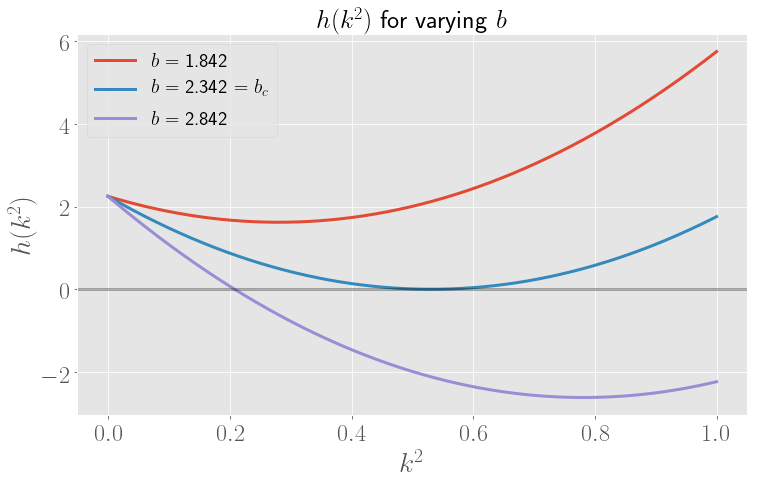

In [33]:
plt.figure(figsize = (12, 7))

# b values we want to plot
b_vals = [bc - 0.5, bc, bc + 0.5]
for b in b_vals:
    ksq_vals = np.arange(0, 1, 0.001)
    h_vals = h(ksq_vals, b)
    km = kmsq(b)
    
    if b == bc:
        plt.plot(ksq_vals, h_vals, label = '$b = $ % 0.3f $ = b_c$' % b)
    else:
        plt.plot(ksq_vals, h_vals, label = '$b = $ % 0.3f' % b)
    
    #plt.scatter(km, h(km, b), color = 'black', zorder = 10)

# Make fancy, save and show
plt.axhline(y = 0, color = 'black', alpha = 0.3)
plt.legend(fontsize = 20)
plt.xlabel(r'$k^2$')
plt.ylabel(r'$h(k^2)$')
plt.title(r'$h(k^2)$ for varying $b$')
plt.savefig('h_functions.pdf', bbox_inches = 'tight')
plt.show()

$ \textbf{Growth rates} $

In [11]:
def sigma_k(ksq, b, gamma = 1, a = 1.5, d = 22.4/2.8):
    '''Computes growth rates. Note: returns complex numbers!'''
    
    under_sqrt = complex((ksq*(1 + d) - gamma*(b - 1 - a**2))**2 - 4*h(ksq, b))
    sigma_k = 0.5*(gamma*(b - 1 - a**2) - ksq*(1 + d) + cmath.sqrt(under_sqrt))
    
    # sigma_k is now a complex number
    return sigma_k

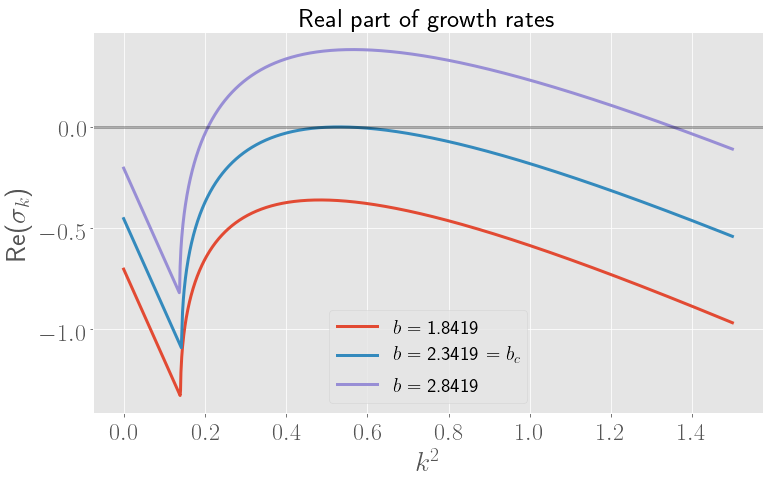

In [31]:
plt.figure(figsize = (12, 7))

ksq_vals = np.arange(0, 1.5, 0.001)

# Need to use a for loop, since we have to take the real part each time

b_vals = [bc - 0.5, bc, bc + 0.5]
for b in b_vals:

    sigma_k_vals = []
    for ksq in ksq_vals:
        sigma_k_vals.append(sigma_k(ksq, b).real)
    
    if b == bc:
        plt.plot(ksq_vals, sigma_k_vals, label = r'$b = $ %0.4f $ = b_c$' % b)
    else:
        plt.plot(ksq_vals, sigma_k_vals, label = r'$b = $ %0.4f' % b)

# Make fancy, save and show
plt.axhline(y = 0, color = 'black', alpha = 0.3)
plt.xlabel(r'$k^2$')
plt.ylabel(r'Re($\sigma_k$)')
plt.title('Real part of growth rates')
plt.legend(fontsize = 20)
plt.savefig('growth_rates.pdf', bbox_inches = 'tight')
plt.show()

## 9.3 - Spatiotemporal behaviour

We first define/repeat a bunch of functions which will allow us to solve the PDE of the Brusselator model.

In [14]:
L = 10
gamma = L**2/2.8

### 9.3.1 - Setting up the PDE solver

In [15]:
def get_x_values(a, b, N):
    '''Gives the x-values and separation in the partition, of length N, of the interval a, b'''
    
    x_vals= np.linspace(a, b, N)
    DeltaX = abs(x_vals[1] - x_vals[0])
    
    return x_vals, DeltaX

The reaction functions for this model.

In [16]:
def reaction_func_u(u, v, b, a = 1.5):
    
    return a - (b+1)*u + u**2*v

In [17]:
def reaction_func_v(u, v, b):
    
    return b*u - u**2*v

To compute the right hand sides:

In [18]:
def u_0_dot(u0, u1, v0, b, DeltaX, reaction_func = reaction_func_u, reaction = 1):
    
    return ((1/DeltaX)**2)*(u1 - u0) + gamma*reaction*reaction_func(u0, v0, b)

In [19]:
def v_0_dot(v0, v1, u0, b, DeltaX, d = 22.4/2.8, reaction_func = reaction_func_v, reaction = 1):
    
    return d*((1/DeltaX)**2)*(v1 - v0) + gamma*reaction*reaction_func(u0, v0, b)

In [20]:
def u_n_dot(unm1, un, unp1, vn, b, DeltaX, reaction_func = reaction_func_u, reaction = 1):
    
    return ((1/DeltaX)**2)*(unp1 - 2*un + unm1) + gamma*reaction*reaction_func(un, vn, b)

In [21]:
def v_n_dot(vnm1, vn, vnp1, un, b, DeltaX, d = 22.4/2.8, reaction_func = reaction_func_v, reaction = 1):
    
    return d*((1/DeltaX)**2)*(vnp1 - 2*vn + vnm1) + gamma*reaction*reaction_func(un, vn, b)

In [22]:
def u_Nm1_dot(uNm2, uNm1, vNm1, b, DeltaX, reaction_func = reaction_func_u, reaction = 1):
    
    return ((1/DeltaX)**2)*(uNm2 - uNm1) + gamma*reaction*reaction_func(uNm1, vNm1, b)

In [23]:
def v_Nm1_dot(vNm2, vNm1, uNm1, b, DeltaX, d = 22.4/2.8, reaction_func = reaction_func_v, reaction = 1):
    
    return d*((1/DeltaX)**2)*(vNm2 - vNm1) + gamma*reaction*reaction_func(uNm1, vNm1, b)

Solver for a system of two PDE's:

In [24]:
def solve_PDE_2D(left_bound, right_bound, N, in_conds_list, t_vals, b, reaction_func_list = [reaction_func_u, reaction_func_v], Du = 2.8, Dv = 22.4, reaction = 1):
    '''Solves a reaction-diffusion PDE, like the Fisher-Kolmogorov equation'''
        
    L = abs(right_bound - left_bound)
    gamma = L**2/2.8
    d = Dv/Du
    
    # Get x values and Delta X separation (same for both u and v)
    x_vals, DeltaX = get_x_values(left_bound, right_bound, N)
    
    # Return values: dictionary with at each x_n point, the list of u_n points, for all times integrated
    return_values_u = {}; return_values_v = {}
    
    # Last values:  when a new value at x_n is computed, store it for the next calculation (faster computations)
    last_values_u = {}; last_values_v = {}
    
    # Get reaction functions
    reaction_func_u, reaction_func_v = reaction_func_list[0], reaction_func_list[1]
    
    # Get the initial conditions (list of two lists) NOTE: values should already be computed!
    initial_u, initial_v = in_conds_list[0], in_conds_list[1]
    for i in range(N):
        return_values_u[i] = [initial_u[i]]
        last_values_u[i]= initial_u[i]
        
        return_values_v[i] = [initial_v[i]]
        last_values_v[i] = initial_v[i]
    
    # Get the value of Delta t for calculations (same for both u and v)
    DeltaT = abs(t_vals[1] - t_vals[0])
    
    # Compute all the other values at all other times
    for t in t_vals:
        if t == t_vals[0]:
            
            # Initial condition: already added, so do nothing in this step
            pass
            
        else:
            for i in range(N):
                if i == 0:
                    
                    new_u0_value = last_values_u[i] + u_0_dot(last_values_u[i], last_values_u[i + 1], last_values_v[i], b, DeltaX, reaction_func_u, reaction)*DeltaT
                    return_values_u[i].append(new_u0_value)
                    last_values_u[i] = new_u0_value
                    
                    new_v0_value = last_values_v[i] + v_0_dot(last_values_v[i], last_values_v[i + 1], last_values_u[i], b, DeltaX, d,  reaction_func_v, reaction)*DeltaT
                    return_values_v[i].append(new_v0_value)
                    last_values_v[i] = new_v0_value
                    
                elif i == N - 1:
                    
                    new_uNm1_value = last_values_u[i] + u_Nm1_dot(last_values_u[i - 1], last_values_u[i], last_values_v[i], b, DeltaX, reaction_func_u, reaction)*DeltaT
                    return_values_u[i].append(new_uNm1_value)
                    last_values_u[i] = new_uNm1_value
                    
                    new_vNm1_value = last_values_v[i] + v_Nm1_dot(last_values_v[i - 1], last_values_v[i], last_values_u[i], b, DeltaX, d, reaction_func_v, reaction)*DeltaT
                    return_values_v[i].append(new_vNm1_value)
                    last_values_v[i] = new_vNm1_value
                    
                else: # 1 <= i <= N-2
                    
                    new_un_value = last_values_u[i] + u_n_dot(last_values_u[i - 1], last_values_u[i], last_values_u[i+1], last_values_v[i], b, DeltaX, reaction_func_u, reaction)*DeltaT
                    return_values_u[i].append(new_un_value)
                    last_values_u[i] = new_un_value
                    
                    new_vn_value = last_values_v[i] + v_n_dot(last_values_v[i - 1], last_values_v[i], last_values_v[i+1], last_values_u[i], b, DeltaX, d, reaction_func_v, reaction)*DeltaT
                    return_values_v[i].append(new_vn_value)
                    last_values_v[i] = new_vn_value
            
    return return_values_u, return_values_v, x_vals

In [25]:
def get_y_values(values, x_vals, index = -1):
    '''Get the numerical values at a certain index (time). Default is last computed value.'''
    
    # Get the final value for each x point
    y_vals = []
    for i in range(len(x_vals)):
        y_vals.append(values[i][index])
    
    return y_vals

### 9.3.2 - Numerical exploration of the dynamics

Below, we are interested in a finite domain size of the form $x \in [0, L]$ with zero flux boundary conditions. The scale parameter $\gamma$ becomes important as well.

Define functions which give the range of wavenumbers in which perturbations should grow.

In [35]:
def compute_k_bounds(b, L, a = 1.5, d = 22.4/2.8):
    '''Gives the range of unstable wavelengths for a certain set-up.'''
    gamma = L**2/2.8
    c = d*(b-1) - a**2
    
    k_m_sq = gamma/(2*d)*(c - np.sqrt(c**2 - 4 *d*a**2))
    k_p_sq = gamma/(2*d)*(c + np.sqrt(c**2 - 4 *d*a**2))
    
    return k_m_sq, k_p_sq

In [44]:
def u_in_sine(x, L, n =1, A = 0.1, a = 1.5):
    return a + A*np.cos((n*np.pi*x)/(L))

In [45]:
def v_in_sine(x, L, b, n =1, A = 0.1, a = 1.5):
    return a/b + A*np.cos((n*np.pi*x)/(L))

#### Varying $b$

Recall the bounds on $b$

In [41]:
print('b has to lie between %0.4f and %0.2f' % (b_lower_bound, b_upper_bound))

b has to lie between 1.2812 and 3.25


In [ ]:
# Parameters:

b_vals = np.linspace(1.5, 3, 4)
L = 10; N = 200
t_vals = np.arange(0, 3, 0.0001)
x_vals, DeltaX = get_x_values(0, L, N)
title_list = ['b = %0.1f' % b for b in b_vals]

# Plot
fig, axs = plt.subplots(2, 2, figsize = (30, 30))
for i in range(len(b_vals)):
    ax = axs[i//2, i%2]; b = b_vals[i]; title = title_list[i]
    
    
    
    # Compute initial condition
    u_initial = u_in_sine(x_vals, L,)
    v_initial  = v_in_sine(x_vals, L, b)
    
    # Compute and get values
    u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)
    u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)
    
    ax.plot(x_vals, u_vals)
    
    
    ax.set_title(title, fontsize = 33)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u$')

plt.suptitle(r'Varying $b$', fontsize = 50)
plt.savefig('varying_b.pdf', bbox_inches = 'tight')
plt.show()

#### Varying the initial condition

(1) A sine wave on top of HSS

0.3141592653589793
24.103856901274078 50.290003729593145
This perturbation should vanish.


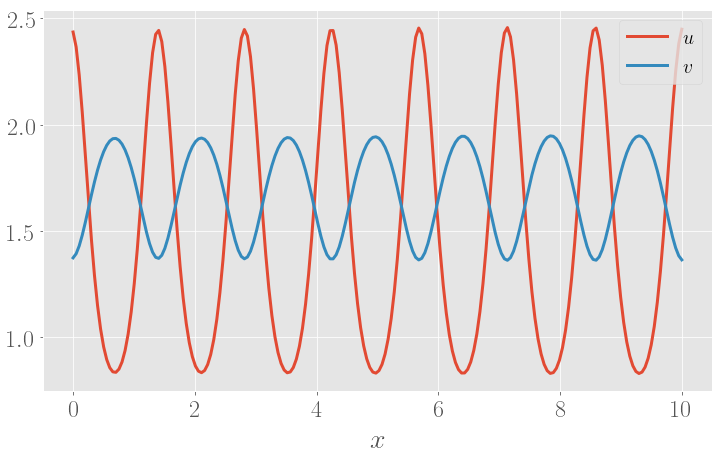

In [30]:
# Set parameters
L = 10; gamma = L**2/2.8; d = 8; N = 200

b = bc + 0.3
t_vals = np.arange(0, 2, 0.0001)

# Compute initial condition
x_vals, DeltaX = get_x_values(0, L, N)
n = 1 # number of wavelengths in sine wave
u_initial = u_in_sine(x_vals, L, n)
v_initial  = v_in_sine(x_vals, L, n, b)

# # Check if it lies in the range for growing perturbations or not
# k = n*np.pi/L
# print(k)
# k_minus, k_plus = compute_k_bounds(b)
# print(k_minus, k_plus)
# if k >= k_minus and k<= k_plus:
#     print('This perturbation should grow.')
# else:
#     print('This perturbation should vanish.')

# Compute all values
u_vals_dict, v_vals_dict, x_vals = solve_PDE_2D(0, L, N, [u_initial, v_initial], t_vals, b)

# Get values at last t
u_vals = get_y_values(u_vals_dict, x_vals); v_vals = get_y_values(v_vals_dict, x_vals)

# Plot
plt.figure(figsize = (12, 7))
plt.plot(x_vals, u_vals, label = r'$u$')
plt.plot(x_vals, v_vals, label = r'$v$')
plt.legend(fontsize = 20)
plt.xlabel(r'$x$')
#plt.ylabel(r'$u$/$v$')
plt.show()

Source: https://stackoverflow.com/questions/32237769/defining-a-white-noise-process-in-python

#### Varying the domain size